# Analysis

## Setup

In [1]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings

The 'ecrest' class has been imported from eCREST_cli.py

An instance of this object will be able to:
- open an neuroglancer viewer for proofrieading (see "Proofread using CREST")
    - add-remove segments (using graph feature for efficiency)
    - format itself and save itself as a CREST-style .json
- convert from neuroglancer json (see "Convert From Neuroglancer to eCREST")
    - format itself and save itself as a CREST-style .json
    


### Import settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [2]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

In [381]:
dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

## Load graph dataframes and visualize

In [1914]:
savepath = Path('/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/graphs/')

df_syn_pre = pd.read_csv(savepath / 'df_presyn.csv')
df_syn_post = pd.read_csv(savepath / 'df_postsyn.csv')

In [1915]:
nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child

In [1916]:
cell_type = {}
not_typed = []
for x in nodefiles.keys():
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        cell_type[x]=''
        not_typed.append(x)# print(f'cell {x} is not cell-typed in json')
        
print('the following cells are not typed in the main network')
print(not_typed)        
        

the following cells are not typed in the main network
['214799227', '215988767', '300643106', '308504510', '45356019', '45444904', '47537491', '48619460']


In [1867]:
file_size = {}
for x in nodes:
    file_size[x] = nodefiles[x].stat().st_size
    

In [ ]:
file_size

In [1877]:
soma_size = {}
for x in nodefiles.keys():
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    all_segs = [a for b in cell.cell_data['base_segments'].values() for a in b]
    if len(cell.cell_data['base_segments']['unknown']) < len(all_segs):
        soma_size[x]=len(cell.cell_data['base_segments']['unknown'])
    if len(cell.cell_data['base_segments']['unknown']) == len(all_segs):
        soma_size[x]=np.NaN
        # print(f'structures not labeled for {cell.cell_data["metadata"]["main_seg"]["base"]}')



In [1893]:
df = pd.DataFrame(soma_size.items(), columns=['cell', 'soma size']).set_index('cell')

for c in df.index:
    df.loc[c,'type'] = cell_type[c]



In [1894]:
df = df[df['type'].isin(['mg1','mg2','sg1','sg2'])]

In [1903]:
df['binned'] = pd.cut(df['soma size'], bins=np.arange(0,4000,200)).values

In [1908]:
len(df[(df['soma size']>800) & (df['soma size']<1200)])


33

<AxesSubplot:xlabel='soma size', ylabel='Count'>

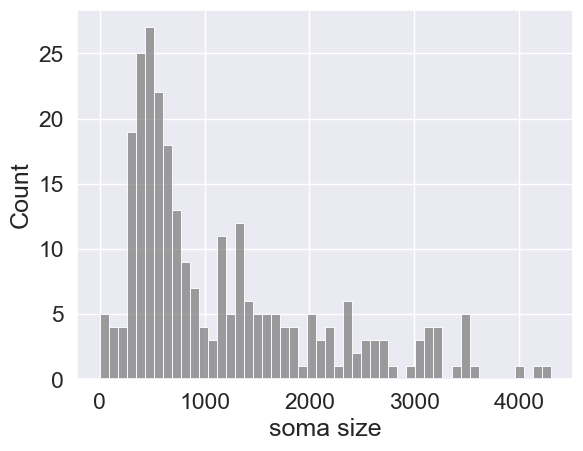

In [1750]:
ax = sns.histplot(data = df,x='soma size',bins = 50,color='gray')
# sns.kdeplot(data = df[df['type'].isin(['mg1','mg2','sg1','sg2'])],x='soma size',bw_adjust=0.25,cut=0)

array([[<AxesSubplot:title={'center':'soma size'}>]], dtype=object)

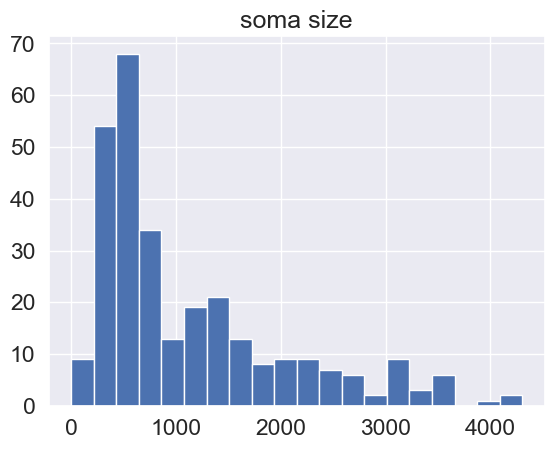

In [1882]:
df[df['type'].isin(['mg1','mg2','sg1','sg2'])].hist(bins = 20)

In [1873]:
df = pd.DataFrame(file_size.items(), columns=['cell', 'file size']).set_index('cell')

for c in df.index:
    df.loc[c,'type'] = cell_type[c]



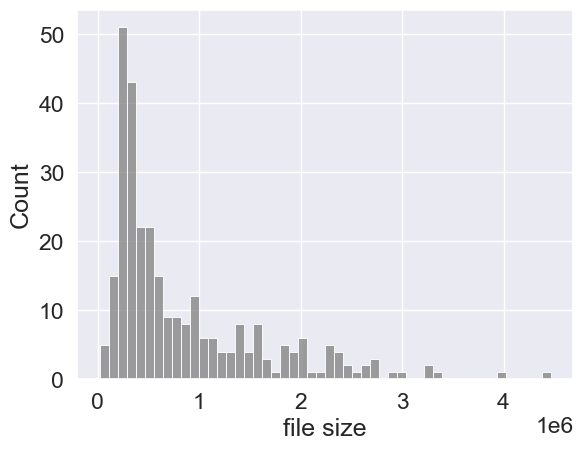

In [1874]:
ax = sns.histplot(data = df[df['type'].isin(['mg1','mg2','sg1','sg2'])],x='file size',bins = 50,color='gray')
# sns.kdeplot(data = df[df['type'].isin(['mg1','mg2','sg1','sg2'])],x='soma size',bw_adjust=0.25,cut=0)

### Completeness of synapses

In [1917]:
df_syn = df_syn_pre
syn = 'pre-synaptic'
c_type_check = ['mg2']#['mg1','mg2','sg1','sg2','grc']

df_progress = pd.DataFrame(columns = ['id','type','n','done','todo','ratio'])
for c in df_syn['pre'].unique():
    
    if (cell_type[str(c)] in c_type_check):
        c_df = df_syn[df_syn['pre'].isin([c])]
        
        cell = ecrest(settings_dict,filepath = nodefiles[str(c)],launch_viewer=False)
               
        cell_dict = {
            'id': cell.cell_data['metadata']['main_seg']['base'],
            'type': cell.get_ctype("manual"),
            'n': len(cell.cell_data['end_points'][syn]),
            'done': len(c_df),
            'todo': len(cell.cell_data['end_points'][syn]) - len(c_df),
            'ratio': len(c_df) / (len(cell.cell_data['end_points'][syn]))
            }
        # print(df_progress)
        df_progress = pd.concat([df_progress,pd.DataFrame([cell_dict])])

# df_progress



In [1918]:
df_progress

,id,type,n,done,todo,ratio
0,214581797,mg2,582,365,217,0.627148
0,386392158,mg2,206,167,39,0.810680
0,472361842,mg2,10,1,9,0.100000


#### Create edges dataframe to look at matrix among most completed

In [1676]:
df_result = df_progress[df_progress['ratio']>=0.95]
display(df_result['type'].value_counts())

mg1    6
mg2    4
sg2    4
sg1    3
Name: type, dtype: int64

In [1677]:
df_edges = df_syn_post[['pre','post']].value_counts().reset_index(name='weight')

df_edges = df_edges[df_edges['pre'].isin([int(v) for v in df_result.id.values])]

for i,r in df_edges.iterrows():
    df_edges.loc[i,'pre_type']=cell_type[str(df_edges.loc[i,'pre'])]
    df_edges.loc[i,'post_type']=cell_type[str(df_edges.loc[i,'post'])]

# for each unique edge, get the cell-type pair and structure
# for i,r in df_edges.iterrows():
#     ell.add_edge(r['pre'],r['post'],weight = r['weight'])#r['weight_norm'])#,structure = r['structure'])

In [1658]:
# network_types = ['mg1','mg2','lg','lf','sg1','sg2','grc','aff']

# df_edges = df_edges[(df_edges['pre_type'].isin(network_types))&(df_edges['post_type'].isin(network_types))]

post_type,mg1,mg2,sg1,sg2
pre_type,,,,
mg1,1.0,96.0,0.0,3.0
mg2,89.0,2.0,9.0,0.0
sg1,0.0,79.0,0.0,21.0
sg2,79.0,0.0,18.0,3.0


Text(41.25, 0.5, 'pre type')

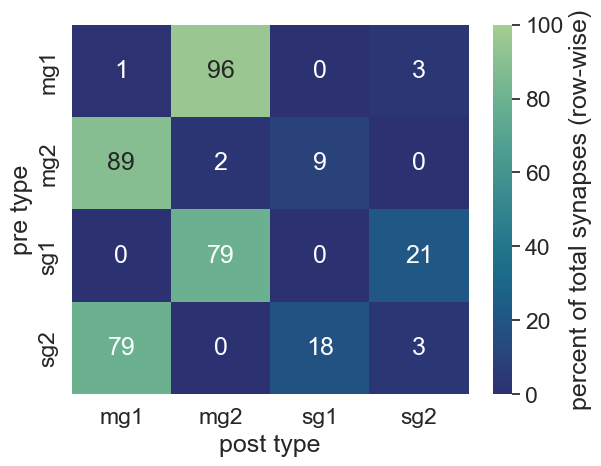

In [1679]:
network_types = ['mg1','mg2','sg1','sg2']#,'lg','lf','sgx','grc','aff']

res = df_edges[(df_edges['pre_type'].isin(network_types))&(df_edges['post_type'].isin(network_types))].groupby(
    ['pre_type','post_type'])[['weight']].sum(numeric_only=True)#.reset_index()

denom = res.groupby('pre_type')['weight'].sum()

res.weight = np.round(res.weight / denom *100)

# res.reset_index().pivot(index='pre_type', columns='post_type', values='weight').fillna(0)

display(res.reset_index().pivot(index='pre_type', columns='post_type', values='weight').fillna(0))

ax = sns.heatmap(res.reset_index().pivot(index='pre_type', columns='post_type', values='weight').fillna(0),
            annot=True,cmap="crest_r",vmin=0,vmax=100,
           cbar_kws={'label': 'percent of total synapses (row-wise)'})

ax.set_xlabel('post type')
ax.set_ylabel('pre type')

### Specific cell examples

In [1809]:
focal_cell_id = 392042360

print(f'soma has {soma_size[str(focal_cell_id)]} segments')

print(f'postsynaptic (targets) from {len(df_syn_post[df_syn_post["pre"]==focal_cell_id])} synapses')
display(df_syn_post[df_syn_post['pre']==focal_cell_id][['post','post_type']].value_counts().reset_index(
    name='weight')['post_type'].value_counts().reset_index(name='ncells'))

display(df_syn_post[df_syn_post['pre']==focal_cell_id][['post','post_type']].value_counts().reset_index(name='weight'))

display(df_progress[df_progress['id']==str(focal_cell_id)])

soma has 275 segments
postsynaptic (targets) from 0 synapses


,index,ncells


,post,post_type,weight


,id,type,n,done,todo,ratio


In [1810]:
focal_cell_id = 392042360

print(f'soma has {soma_size[str(focal_cell_id)]} segments')

print(f'presynaptic (target) of {len(df_syn_pre[df_syn_pre["pre"]==focal_cell_id])} synapses')
display(df_syn_pre[df_syn_pre['pre']==focal_cell_id][['post','post_type']].value_counts().reset_index(
    name='weight')['post_type'].value_counts().reset_index(name='ncells'))

display(df_syn_pre[df_syn_pre['pre']==focal_cell_id][['post','post_type']].value_counts().reset_index(name='weight'))

display(df_progress[df_progress['id']==str(focal_cell_id)])

soma has 275 segments
presynaptic (target) of 0 synapses


,index,ncells


,post,post_type,weight


,id,type,n,done,todo,ratio


In [1440]:
focal_cell_id = 386426114

print('presynaptic (inputs) from post-synaptically labeled/reconstructed dataset')
# display(df_syn_post[df_syn_post['pre']==focal_cell_id][['pre','pre_type']].value_counts().reset_index(
#     name='weight')['post_type'].value_counts().reset_index(name='ncells'))


display(df_syn_post[df_syn_post['post']==focal_cell_id][['pre','pre_type']].value_counts().reset_index(name='weight'))



presynaptic (inputs) from post-synaptically labeled/reconstructed dataset


,pre,pre_type,weight
0,297178666,mli,4
1,299589324,sg,4
2,302700562,sgx,2
3,61319896,aff,1
4,129943799,sg1,1
5,299496636,mg1,1
6,301662524,sgx,1


### distributions of synapses

In [1684]:
df_syn_post

,Unnamed: 0,pre,post,x,y,z,pre_type,post_type
0,0,126618353,387850816,23099,19611,1742,mg1,mg2
1,1,126618353,303212610,23046,19674,1752,mg1,mg2
2,2,126618353,394686712,23132,19677,1754,mg1,lf
3,3,126618353,394686712,22487,19663,1713,mg1,lf
4,4,126618353,213605530,22506,19613,1713,mg1,mg2
...,...,...,...,...,...,...,...,...
6780,6780,648567066,645162652,13895,18330,3076,sg2,lg
6781,6781,648567066,645162652,14072,18129,3077,sg2,lg
6782,6782,648567066,559258918,14112,18124,3077,sg2,sg1
6783,6783,648567066,645162652,14085,17953,3071,sg2,lg


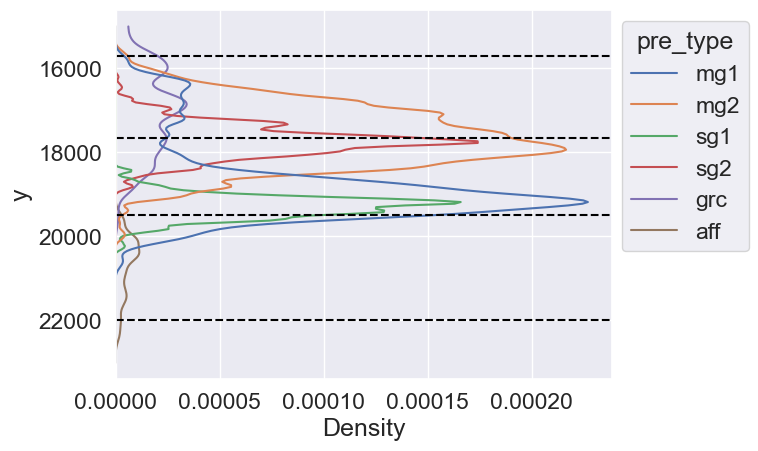

In [1682]:
network_types = ['mg1','mg2','lg','lf','sg1','sg2','grc','aff']
ax = sns.kdeplot(data = df_syn_post[(df_syn_post['pre_type'].isin(network_types))&(df_syn_post['post_type'].isin(network_types))], 
            y = 'y', hue='pre_type',
           cut=0,clip=[23000,15000], common_norm=True, bw_adjust=0.5)#, cumulative=True)

ax.invert_yaxis()
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))

for y_ in [22000, 19500, 17650, 15700]:
    ax.axhline(y=y_,color = 'black',linestyle='--')

### sg vs mg synapses by file size

In [1701]:
network_types = ['mg1','mg2','sg1','sg2']

df_sub = df_syn_post[(df_syn_post['pre_type'].isin(network_types))&(df_syn_post['post_type'].isin(network_types))]

In [1702]:
df_result = pd.DataFrame(columns = ['pre','pre_type','mg','sg','fsize','ssize'])

for k in df_sub['pre'].unique():
    # print(df_sub[df_sub['pre']==k])
    cell_df = df_sub[df_sub['pre']==k]
    if cell_df['pre_type'].isin(['sg1','mg1']).sum() > 0:
        w_sg = len(cell_df[cell_df['post_type']=='sg2'])
        w_mg = len(cell_df[cell_df['post_type']=='mg2'])
    if cell_df['pre_type'].isin(['sg2','mg2']).sum() > 0:
        w_sg = len(cell_df[cell_df['post_type']=='sg1'])
        w_mg = len(cell_df[cell_df['post_type']=='mg1'])
    
    cell_dict = {
        'pre': k,
        'pre_type': cell_df['pre_type'].unique()[0],
        'mg': w_mg,
        'sg': w_sg,
        'fsize': file_size[str(k)],
        'ssize': soma_size[str(k)]
    }
    
    df_result = pd.concat([df_result,pd.DataFrame([cell_dict])])

In [1703]:
df_result.groupby('pre_type').sum()

,pre,mg,sg,fsize,ssize
pre_type,,,,,
mg1,9490784954,485,10,41612846,56268
mg2,13038615827,541,16,66172528,79638
sg1,3365603713,251,30,6400334,7676
sg2,5712205292,268,113,7036506,9273


<AxesSubplot:xlabel='fsize', ylabel='ssize'>

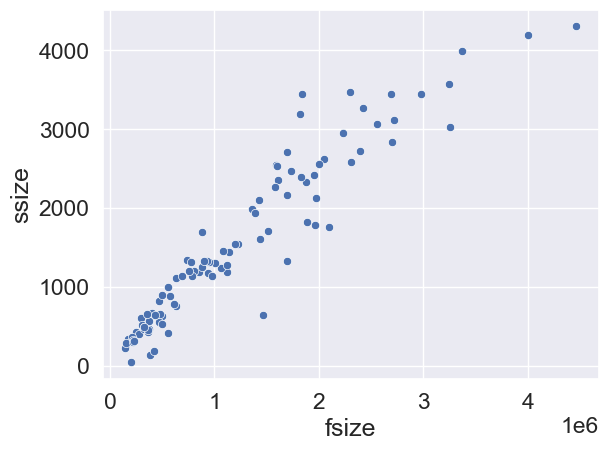

In [1688]:
sns.scatterplot(data=df_result,x='fsize',y='ssize')

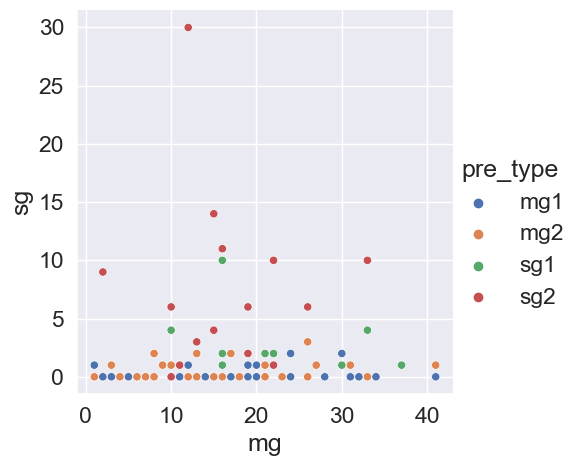

In [1689]:
sns.relplot(data=df_result,y='sg',x='mg',hue='pre_type')#,size='fsize')

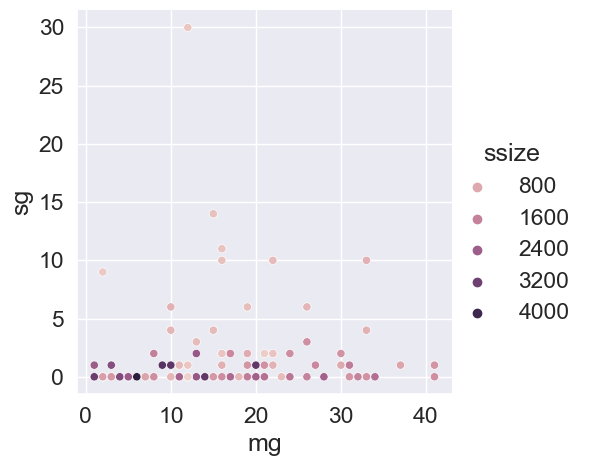

In [1704]:
sns.relplot(data=df_result,y='sg',x='mg',hue='ssize')#,size='fsize')

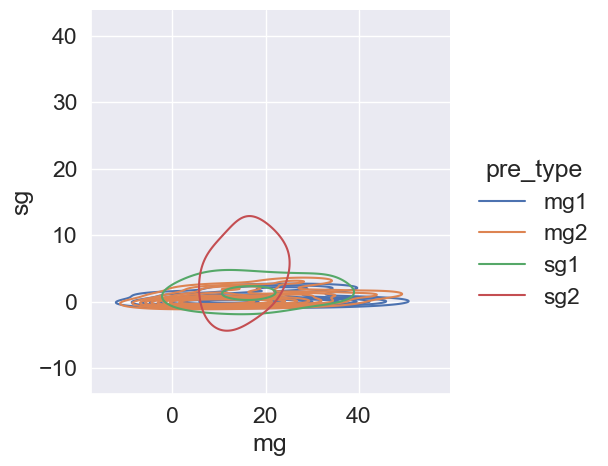

In [1691]:
ax = sns.displot(data=df_result,y='sg',x='mg',hue='pre_type', kind="kde")
# ax.set_ylims(-5,5)

In [1692]:
print(df_result[df_result['pre_type'].isin(['mg1'])][['mg','sg']].mean())

print(df_result[df_result['pre_type'].isin(['mg2'])][['mg','sg']].mean())

print(df_result[df_result['pre_type'].isin(['sg1'])][['mg','sg']].mean())

print(df_result[df_result['pre_type'].isin(['sg2'])][['mg','sg']].mean())

mg    16.724138
sg     0.344828
dtype: float64
mg    13.871795
sg     0.410256
dtype: float64
mg    17.928571
sg     2.142857
dtype: float64
mg    15.764706
sg     6.647059
dtype: float64


In [1707]:
df_result = df_sub[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')

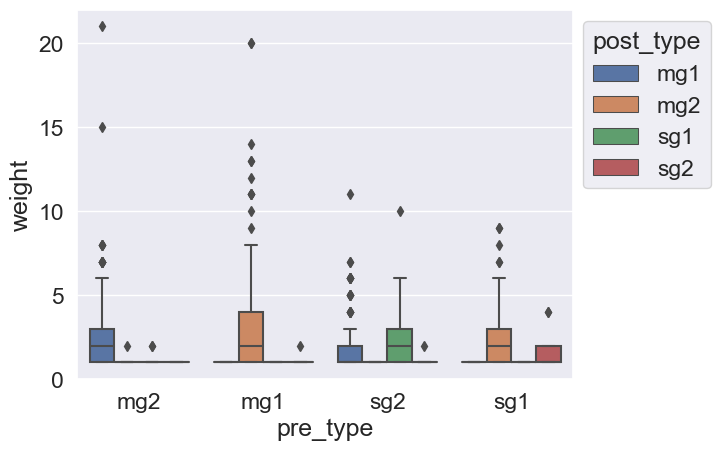

In [1695]:
ax = sns.boxplot(data = df_result, x = 'pre_type',y='weight',hue='post_type')#,dodge=True,jitter=0.25)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))

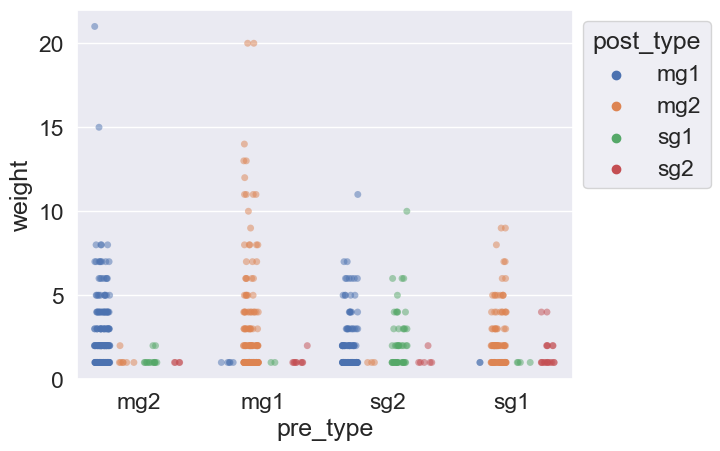

In [1696]:
ax = sns.stripplot(data = df_result, x = 'pre_type',y='weight',hue='post_type',dodge=True,jitter=0.25,alpha=0.5)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))

In [1708]:
df_result['pre_size'] = [soma_size[str(k)] for k in df_result['pre']]

df_result['post_size'] = [soma_size[str(k)] for k in df_result['post']]

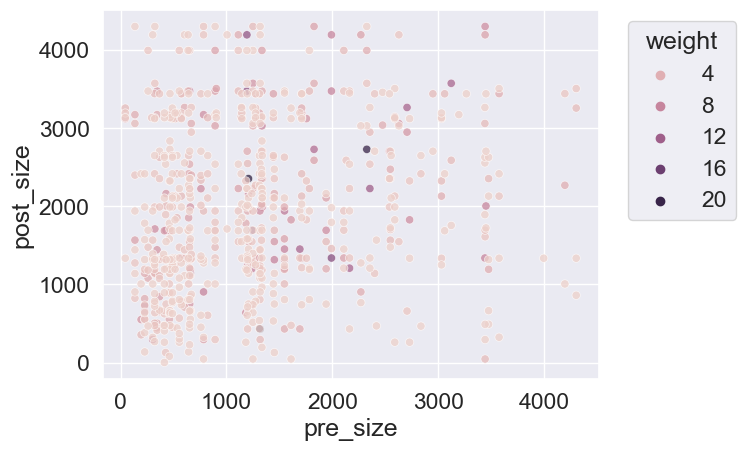

In [1698]:
ax = sns.scatterplot(data = df_result,x='pre_size',y='post_size',hue = 'weight',alpha = 0.75)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))

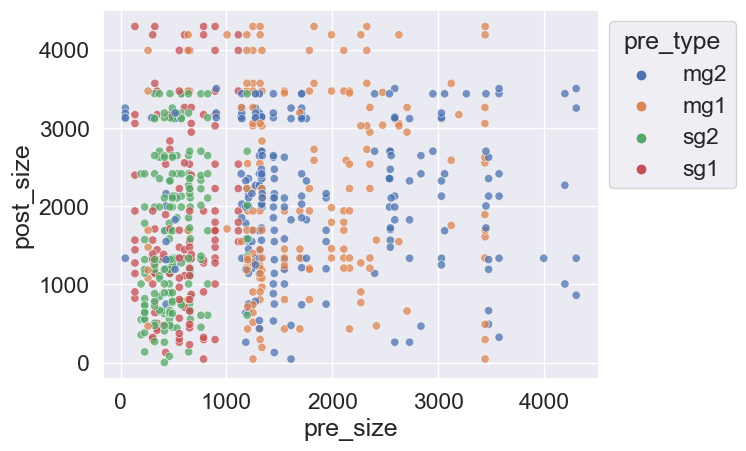

In [1709]:
ax = sns.scatterplot(data = df_result,x='pre_size',y='post_size',hue = 'pre_type',alpha = 0.75)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))

### Edges dataframe

In [1660]:
df_edges=df_syn_post[['pre','post']].value_counts().reset_index(name='weight')

In [1661]:
for i,r in df_edges.iterrows():
    df_edges.loc[i,'pre_type']=cell_type[str(df_edges.loc[i,'pre'])]
    df_edges.loc[i,'post_type']=cell_type[str(df_edges.loc[i,'post'])]

# for each unique edge, get the cell-type pair and structure
# for i,r in df_edges.iterrows():
#     ell.add_edge(r['pre'],r['post'],weight = r['weight'])#r['weight_norm'])#,structure = r['structure'])

In [1662]:
network_types = ['mg1','mg2','lg','lf','sg1','sg2','sgx','grc','aff']

df_edges = df_edges[(df_edges['pre_type'].isin(network_types))&(df_edges['post_type'].isin(network_types))]

In [1664]:
# df_edges[["pre_type","post_type"]].value_counts()

In [933]:
# print(f'comprising {len(df_edges)} unique edges among:')
print(f'{df_edges[["pre_type","post_type"]].value_counts().reset_index(name="counts")["counts"].sum()} unique edges among:')
print(f'{len(df_edges["pre"].unique())} unique pre synaptic cells - to - {len(df_edges["post"].unique())} unique post-synaptic cells (counts different structures on same cell as same)')

1373 unique edges among:
121 unique pre synaptic cells - to - 305 unique post-synaptic cells (counts different structures on same cell as same)


In [ ]:
df_edge_counts = df_edges[['pre_type','post_type']].value_counts().reset_index(name='counts')

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg1']) & df_edge_counts['post_type'].str.lower().isin(['lf'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg1']) & df_edges['post_type'].str.lower().isin(['lf'])
display(df_edges[mask].groupby(['pre_type','post_type']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg2']) & df_edge_counts['post_type'].str.lower().isin(['lg'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg2']) & df_edges['post_type'].str.lower().isin(['lg'])
display(df_edges[mask].groupby(['pre_type','post_type']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg1']) & df_edge_counts['post_type'].str.lower().isin(['mg2'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg1']) & df_edges['post_type'].str.lower().isin(['mg2'])
display(df_edges[mask].groupby(['pre_type','post_type']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg2']) & df_edge_counts['post_type'].str.lower().isin(['mg1'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg2']) & df_edges['post_type'].str.lower().isin(['mg1'])
display(df_edges[mask].groupby(['pre_type','post_type']).sum(numeric_only=True))

#### Cell Structures included

If want to count different cell structure targets as unique, use the following cell.  

If not, ignore it

In [ ]:
edge_scaling = 10
df = pd.DataFrame(edge_list,columns = ['pre','post','structure'])

df_edges = deepcopy(df.value_counts().reset_index(name='weight'))
df_edges['weight_norm'] = (df_edges['weight'] / df_edges['weight'].max()) * edge_scaling

for i,r in df_edges.iterrows():
    df_edges.loc[i,'pre_type']=ell.vs.find(r['pre'])['cell_type']
    df_edges.loc[i,'post_type']=ell.vs.find(r['post'])['cell_type']

In [ ]:
# for each unique edge, get the cell-type pair and structure
for i,r in df_edges.iterrows():
    ell.add_edge(r['pre'],r['post'],weight = r['weight_norm'],structure = r['structure'])

In [ ]:
# print(f'comprising {len(df_edges)} unique edges among:')
print(f'{df_edges[["pre_type","post_type","structure"]].value_counts().reset_index(name="counts")["counts"].sum()} unique edges among:')
print(f'{len(df["pre"].unique())} unique pre synaptic cells - to - {len(df["post"].unique())} unique post-synaptic cells (counts different structures on same cell as different)')

In [ ]:
df_edge_counts = df_edges[['pre_type','post_type','structure']].value_counts().reset_index(name='counts')

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg1']) & df_edge_counts['post_type'].str.lower().isin(['lf'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg1']) & df_edges['post_type'].str.lower().isin(['lf'])
display(df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg2']) & df_edge_counts['post_type'].str.lower().isin(['lg'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg2']) & df_edges['post_type'].str.lower().isin(['lg'])
display(df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg1']) & df_edge_counts['post_type'].str.lower().isin(['mg2'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg1']) & df_edges['post_type'].str.lower().isin(['mg2'])
display(df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg2']) & df_edge_counts['post_type'].str.lower().isin(['mg1'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg2']) & df_edges['post_type'].str.lower().isin(['mg1'])
display(df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True))

### Check for any synapses on self

In [ ]:
vx_sizes = [16, 16, 30]

for i,r in df_edges.iterrows():
    if r['pre']==r['post']:
        print(r['pre'])
        cell = ecrest(settings_dict,filepath = nodefiles[r['pre']])
        for syn_ in cell.cell_data['end_points']['post-synaptic']:
            post_seg = syn_[3]
            for i,s in enumerate(syn_[0:3]):
                syn_[i] = s/vx_sizes[i] 
            if post_seg in [str(a) for b in base_segments[r['pre']].values() for a in b]:
                print(f'delete synapse {syn_}')       
        

In [934]:
print(f'{len(ell.vs)} cells in the network that fall within cell types of interest (nodes in the graph):')
print('')
for ctype in network_types:
    these_cells = ell.vs.select(lambda v: ctype in v['cell_type'])
    print(f'{len(these_cells)} {ctype} cells.')# {len(ell.vs.select(lambda v: 'lg' in v['cell_type']))} lg cells. {len(e
print('')

df_allsyn = pd.DataFrame(cells_with_synapses)
print(f'{len(df_allsyn[df_allsyn[1].isin(["mg1","mg2"])])} of these are mg cells with post-synaptic segments labeled for their synapses')
# print(f'{len(df_edges[df_edges['pre_type'].str.contains("mg")])} of these are mg_ cells with post-synaptic segments labeled for their synapses')

print(f'{df_allsyn[df_allsyn[1].isin(["mg1","mg2"])][2].sum()} total post-synapstic segments labeled from mg_ cells in the network')

# cells_without_synapses

df_nosyn = pd.DataFrame(cells_without_synapses)

# print(f'{len(df_nosyn[df_nosyn[1].str.contains(["mg1","mg2"])])} mg1/2 cells without labeled synapses')
print(f'{len(df_nosyn[df_nosyn[1].isin(["mg1","mg2"])])} mg1/2 cells without labeled synapses')


######
print('')
print(f'{len(df_allsyn[df_allsyn[1].isin(["sg1","sg2","sgx"])])} of these are sg cells with post-synaptic segments labeled for their synapses')
# print(f'{len(df_edges[df_edges['pre_type'].str.contains("mg")])} of these are mg_ cells with post-synaptic segments labeled for their synapses')

print(f'{df_allsyn[df_allsyn[1].isin(["sg1","sg2","sgx"])][2].sum()} total post-synapstic segments labeled from sg_ cells in the network')

# cells_without_synapses

df_nosyn = pd.DataFrame(cells_without_synapses)

# print(f'{len(df_nosyn[df_nosyn[1].str.contains(["mg1","mg2"])])} mg1/2 cells without labeled synapses')
print(f'{len(df_nosyn[df_nosyn[1].isin(["sg1","sg2","sgx"])])} sg_ cells without labeled synapses')

######
print('')
print(f'{len(df_allsyn[df_allsyn[1].isin(["grc"])])} of these are grc cells with post-synaptic segments labeled for their synapses')
# print(f'{len(df_edges[df_edges['pre_type'].str.contains("mg")])} of these are mg_ cells with post-synaptic segments labeled for their synapses')

print(f'{df_allsyn[df_allsyn[1].isin(["grc"])][2].sum()} total post-synapstic segments labeled from grc cells in the network')

# cells_without_synapses

df_nosyn = pd.DataFrame(cells_without_synapses)

# print(f'{len(df_nosyn[df_nosyn[1].str.contains(["mg1","mg2"])])} mg1/2 cells without labeled synapses')
print(f'{len(df_nosyn[df_nosyn[1].isin(["grc"])])} grc cells without labeled synapses')

457 cells in the network that fall within cell types of interest (nodes in the graph):

61 mg1 cells.
66 mg2 cells.
34 lg cells.
38 lf cells.
69 sg1 cells.
29 sg2 cells.
114 grc cells.
13 aff cells.

78 of these are mg cells with post-synaptic segments labeled for their synapses
5465 total post-synapstic segments labeled from mg_ cells in the network
49 mg1/2 cells without labeled synapses

33 of these are sg cells with post-synaptic segments labeled for their synapses
1914 total post-synapstic segments labeled from sg_ cells in the network
98 sg_ cells without labeled synapses

16 of these are grc cells with post-synaptic segments labeled for their synapses
1009 total post-synapstic segments labeled from grc cells in the network
98 grc cells without labeled synapses


summary of mg

In [935]:
print(f'{len(df_syn_post)} synapses with reconstructed partners in current network,')
print(f'{len(df_edges)} unique edges total (of various weights)')

print('')

print(f'{df_edges[df_edges["pre_type"].str.contains("mg")]["weight"].sum()} synapses with reconstructed partners from mg cells pre-synaptically.')
print(f'{df_edges[df_edges["pre_type"].str.contains("sg")]["weight"].sum()} synapses with reconstructed partners from sg cells pre-synaptically.')
print(f'{df_edges[df_edges["pre_type"].str.contains("grc")]["weight"].sum()} synapses with reconstructed partners from grc cells pre-synaptically.')

print('')

print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="mg1"]["pre"]))} mg1 cells with ')
print(f'{df_edges[df_edges["pre_type"]=="mg1"]["weight"].sum()} connected synapses with a reconstructed partner in these mg1')

print(f'{len(np.unique(df_edges[df_edges["post_type"]=="mg1"]["post"]))} mg1 cells (post)')
print(f'{df_edges[df_edges["post_type"]=="mg1"]["weight"].sum()} connected synapses with a reconstructed partner in these mg1')

print('')
print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="mg2"]["pre"]))} mg2 cells (pre)')
print(f'{df_edges[df_edges["pre_type"]=="mg2"]["weight"].sum()} connected synapses with a reconstructed partner in these mg2')

print(f'{len(np.unique(df_edges[df_edges["post_type"]=="mg2"]["post"]))} mg2 cells (post)')
print(f'{df_edges[df_edges["post_type"]=="mg2"]["weight"].sum()} connected synapses with a reconstructed partner in these mg2')

print('')
print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="sg1"]["pre"]))} sg1 cells (pre) ')
print(f'{df_edges[df_edges["pre_type"]=="sg1"]["weight"].sum()} connected synapses with a reconstructed partner in these sg1')

print(f'{len(np.unique(df_edges[df_edges["post_type"]=="sg1"]["post"]))} sg1 cells (post)')
print(f'{df_edges[df_edges["post_type"]=="sg1"]["weight"].sum()} connected synapses with a reconstructed partner in these sg1')

print('')
print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="sg2"]["pre"]))} sg2 cells (pre)')
print(f'{df_edges[df_edges["pre_type"]=="sg2"]["weight"].sum()} connected synapses with a reconstructed partner in these sg2')

print(f'{len(np.unique(df_edges[df_edges["post_type"]=="sg2"]["post"]))} sg2 cells (post)')
print(f'{df_edges[df_edges["post_type"]=="sg2"]["weight"].sum()} connected synapses with a reconstructed partner in these sg2')

print('')
print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="sgx"]["pre"]))} sgx cells (pre)')
print(f'{df_edges[df_edges["pre_type"]=="sgx"]["weight"].sum()} connected synapses with a reconstructed partner in these sgx')

print(f'{len(np.unique(df_edges[df_edges["post_type"]=="sgx"]["post"]))} sgx cells (post)')
print(f'{df_edges[df_edges["post_type"]=="sgx"]["weight"].sum()} connected synapses with a reconstructed partner in these sgx')

print('')
print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="grc"]["pre"]))} grc cells (pre)')
print(f'{df_edges[df_edges["pre_type"]=="grc"]["weight"].sum()} connected synapses with a reconstructed partner in these grc')

print(f'{len(np.unique(df_edges[df_edges["post_type"]=="grc"]["post"]))} grc cells (post)')
print(f'{df_edges[df_edges["post_type"]=="grc"]["weight"].sum()} connected synapses with a reconstructed partner in these grc')

# with pd.option_context('display.max_rows', 10):
#     display(df_edges)

6186 synapses with reconstructed partners in current network,
1373 unique edges total (of various weights)

3276 synapses with reconstructed partners from mg cells pre-synaptically.
1009 synapses with reconstructed partners from sg cells pre-synaptically.
405 synapses with reconstructed partners from grc cells pre-synaptically.

34 mg1 cells with 
1437 connected synapses with a reconstructed partner in these mg1
55 mg1 cells (post)
802 connected synapses with a reconstructed partner in these mg1

40 mg2 cells (pre)
1839 connected synapses with a reconstructed partner in these mg2
63 mg2 cells (post)
796 connected synapses with a reconstructed partner in these mg2

14 sg1 cells (pre) 
446 connected synapses with a reconstructed partner in these sg1
55 sg1 cells (post)
244 connected synapses with a reconstructed partner in these sg1

15 sg2 cells (pre)
563 connected synapses with a reconstructed partner in these sg2
34 sg2 cells (post)
98 connected synapses with a reconstructed partner i

## If need to delete edges to re-do something...

In [ ]:
# # if need to delete all edges...
# ell.delete_edges(range(len(ell.es)))

## querying df_edges

### print out quantifications

In [407]:
with pd.option_context('display.max_rows', 20):
    display(df_edges)

,pre,post,weight,pre_type,post_type
0,387382792,214503199,40,mg2,lg
1,473631846,305332461,30,mg2,lg
2,41579854,394191803,29,mg1,lf
3,300131090,309277229,29,mg1,lf
4,128536704,214503199,24,mg2,lg
...,...,...,...,...,...
2031,301662524,306306044,1,sgx,uk
2032,301648806,563840037,1,sg1,lf
2033,301648806,483687142,1,sg1,lx
2034,301648806,480158526,1,sg1,uk


If have structure in edges, can use next cells...

In [ ]:
mask = df_edges['pre_type'].str.lower().isin(['sg1','mg1']) & df_edges['post_type'].str.lower().isin(['mg2'])
hfig,ax = plt.subplots(1,figsize=(10,5))
sns.stripplot(ax = ax, x='structure',y='weight',data = df_edges[mask],hue='pre_type', dodge=True, alpha=0.33,jitter=0.33,s=10)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_ylim(0,15)

In [ ]:
mask = df_edges['pre_type'].str.lower().isin(['mg2','sg2']) & df_edges['post_type'].str.lower().isin(['mg1'])
hfig,ax = plt.subplots(1,figsize=(10,5))
sns.stripplot(ax = ax, x='structure',y='weight',data = df_edges[mask],hue='pre_type', dodge=True, alpha=0.33,jitter=0.33,s=10)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_ylim(0,15)

## Graphs

In [185]:
# df_edges[df_edges['pre_type']=='grc']

In [1665]:
# for d_ in df_edges[df_edges['pre_type']=='sg2'].groupby(['pre']):
#     print(d_)

In [ ]:
# df_map = df_edges.
# df_map = df_edges[df_edges['pre_type']=='grc'].groupby(['post_type']).sum(numeric_only=True).reset_index()
# display(df_map)

In [1666]:
df_map = df_edges.groupby(['pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(index='pre_type', columns='post_type', values='weight').fillna(0)
print('raw weights')
display(df_map)
# display(df_map/df_map.sum(axis=1))
print('totals across row')
display(df_map.sum(axis=1))

raw weights


post_type,grc,lf,lg,mg1,mg2,sg1,sg2,sgx
pre_type,,,,,,,,
aff,49.0,13.0,0.0,0.0,9.0,0.0,13.0,4.0
grc,7.0,34.0,80.0,33.0,83.0,145.0,43.0,31.0
mg1,1.0,960.0,0.0,5.0,485.0,2.0,10.0,2.0
mg2,0.0,64.0,1219.0,541.0,8.0,16.0,4.0,4.0
sg1,0.0,193.0,0.0,2.0,251.0,4.0,30.0,6.0
sg2,2.0,0.0,261.0,268.0,3.0,113.0,7.0,4.0
sgx,1.0,64.0,17.0,17.0,59.0,10.0,72.0,10.0


totals across row


pre_type
aff      88.0
grc     456.0
mg1    1465.0
mg2    1856.0
sg1     486.0
sg2     658.0
sgx     250.0
dtype: float64

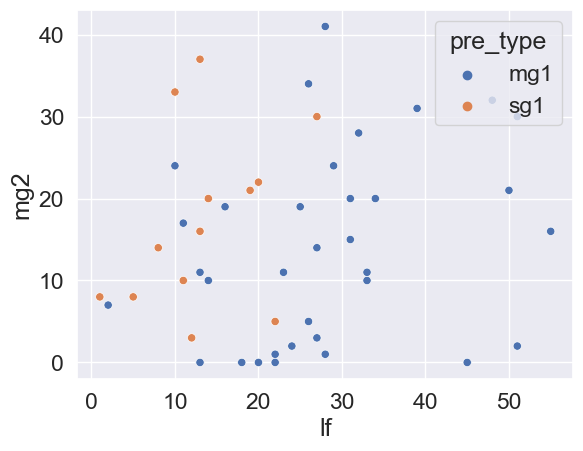

In [1132]:
types_ = ['mg1','sg1']
df_map = pd.DataFrame()
for t in types_:
    df_grouped = df_edges[df_edges['pre_type']==t].groupby(
        ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
        index='pre', columns='post_type', values='weight').fillna(0).reset_index()
    df_grouped['pre_type']=t
    df_map = pd.concat([df_map,df_grouped])
    
# for t in types_:
#     df_grouped = df_edges[df_edges['pre_type']==t].groupby(
#         ['pre','pre_type','post_type']).count().reset_index().pivot(
#         index='pre', columns='post_type', values='post').fillna(0).reset_index()
#     df_grouped['pre_type']=t
#     df_map = pd.concat([df_map,df_grouped])

ax = sns.scatterplot(data=df_map,x='lf',y='mg2',hue='pre_type')

<AxesSubplot:xlabel='lg', ylabel='mg1'>

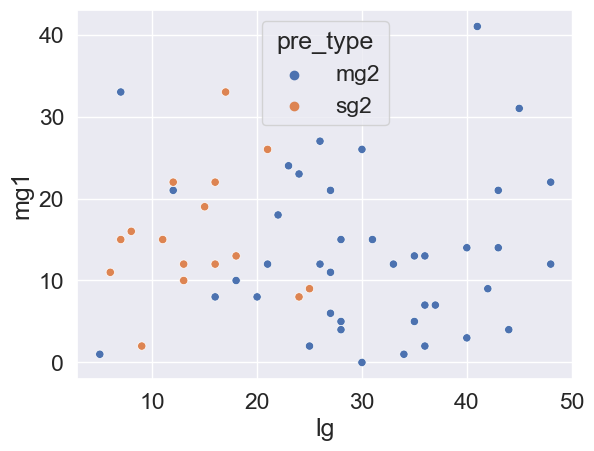

In [1133]:
types_ = ['mg2','sg2']
df_map = pd.DataFrame()
for t in types_:
    df_grouped = df_edges[df_edges['pre_type']==t].groupby(
        ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
        index='pre', columns='post_type', values='weight').fillna(0).reset_index()
    df_grouped['pre_type']=t
    df_map = pd.concat([df_map,df_grouped])

sns.scatterplot(data=df_map,x='lg',y='mg1',hue='pre_type')

In [1667]:
df_map[df_edges['post_type'].unique()].div(df_map[df_edges['post_type'].unique()].sum(axis=1),axis=0).mul(100).round(0)

post_type,lg,lf,mg1,sg1,mg2,sg2,grc,sgx
pre_type,,,,,,,,
aff,0.0,15.0,0.0,0.0,10.0,15.0,56.0,5.0
grc,18.0,7.0,7.0,32.0,18.0,9.0,2.0,7.0
mg1,0.0,66.0,0.0,0.0,33.0,1.0,0.0,0.0
mg2,66.0,3.0,29.0,1.0,0.0,0.0,0.0,0.0
sg1,0.0,40.0,0.0,1.0,52.0,6.0,0.0,1.0
sg2,40.0,0.0,41.0,17.0,0.0,1.0,0.0,1.0
sgx,7.0,26.0,7.0,4.0,24.0,29.0,0.0,4.0


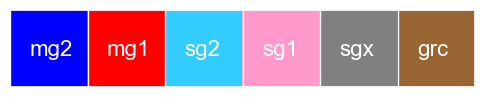

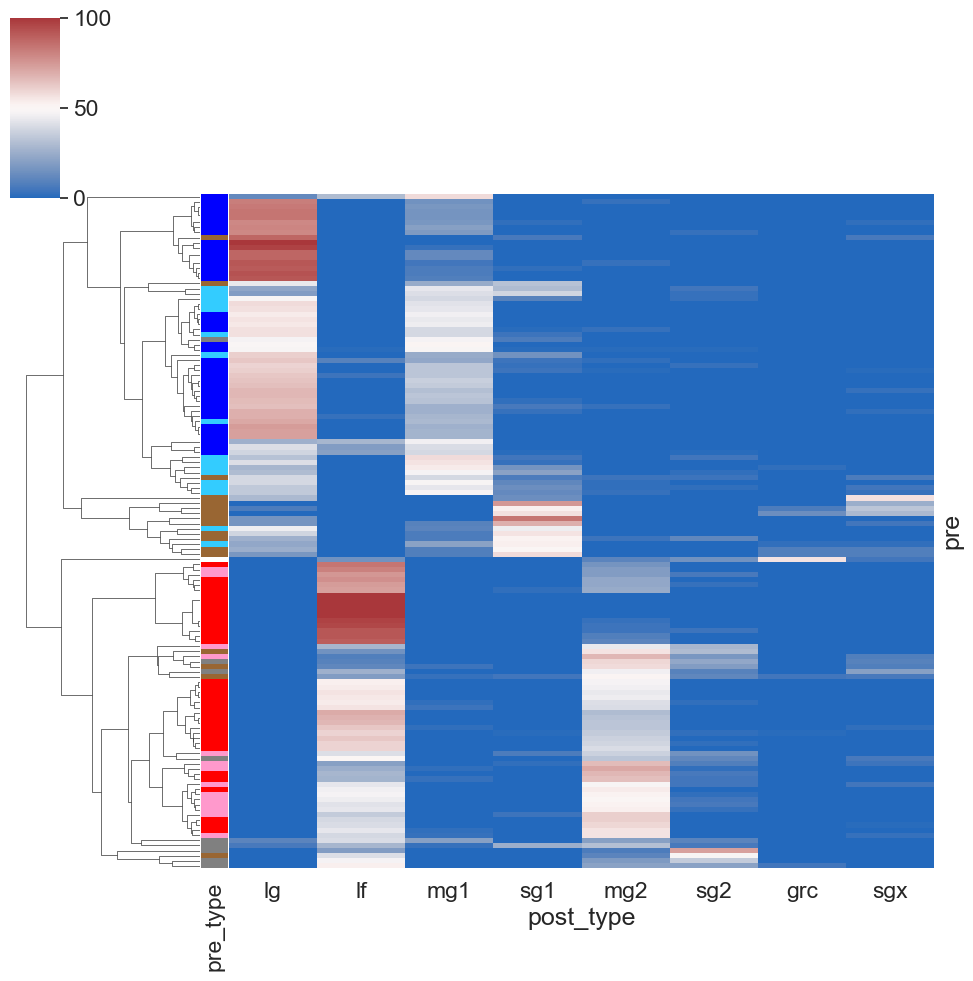

In [1668]:
types_ = ['mg1','mg2','lg','lf','sg1','sg2','sgx','grc','aff']# df_edges['pre_type'].unique()
df_map = pd.DataFrame()
for t in types_:
    df_grouped = df_edges[df_edges['pre_type']==t].groupby(
        ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
        index='pre', columns='post_type', values='weight').fillna(0).reset_index()
    
    # df_grouped = df_edges[df_edges['pre_type']==t].groupby(
    #     ['pre','pre_type','post_type']).count().reset_index().pivot(
    #     index='pre', columns='post_type', values='post').fillna(0).reset_index()
    
    df_grouped['pre_type']=t
    df_map = pd.concat([df_map,df_grouped])
    
df_map = df_map.fillna(0)

df_map = df_map.set_index('pre')


labels = df_map['pre_type'].unique()
color_pal = sns.color_palette("deep", len(labels))
# color_dict = dict(zip(labels, color_pal))
# sns.palplot(sns.color_palette("deep", len(labels)))

color_dict = {
    'mg2': '#0000ff',
    'mg1': '#ff0000',
    'sg2': '#33ccff',
    'sg1': '#ff99cc',
    'sgx': '#808080',
    'grc': '#996633'    
}
sns.palplot(color_dict.values())
ax = plt.gca()
ax.tick_params(left=False, bottom=False)

for i,v in enumerate(color_dict):
    ax.text(i-0.25, 0.1, v,fontsize=16,color='white') 

data_df = df_map[df_edges['post_type'].unique()].div(df_map[df_edges['post_type'].unique()].sum(axis=1),axis=0).mul(100).round(0)
sns.clustermap(data = data_df,
               method='average',
               col_cluster=False, cmap="vlag", center=50,yticklabels=False,
               row_colors = df_map['pre_type'].map(color_dict));

# data_df = df_map[df_edges['post_type'].unique()]
# cmap = sns.color_palette("blend:#d9d9d9,#000000", as_cmap=True)
# cmap.set_under('white')
# sns.clustermap(data = data_df,
#                method='average',
#                col_cluster=False, cmap=cmap, vmin=1, yticklabels=False,
#                row_colors = df_map['pre_type'].map(color_dict));


# The methods are single, complete, average, weighted, ward, median, centroid
# from https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage
# default for seaborn is "average"

#### Connectivity matrices

Use following for network from POSTsynaptic labeling

In [1669]:
df_edges=df_syn_post[['pre','post']].value_counts().reset_index(name='weight')

In [1670]:
for i,r in df_edges.iterrows():
    df_edges.loc[i,'pre_type']=cell_type[str(df_edges.loc[i,'pre'])]
    df_edges.loc[i,'post_type']=cell_type[str(df_edges.loc[i,'post'])]

# for each unique edge, get the cell-type pair and structure
# for i,r in df_edges.iterrows():
#     ell.add_edge(r['pre'],r['post'],weight = r['weight'])#r['weight_norm'])#,structure = r['structure'])

In [1671]:


df_edges = df_edges[(df_edges['pre_type'].isin(network_types))&(df_edges['post_type'].isin(network_types))]

post_type,lf,lg,mg1,mg2,sg1,sg2
pre_type,,,,,,
mg1,66.0,0.0,0.0,33.0,0.0,1.0
mg2,3.0,66.0,29.0,0.0,1.0,0.0
sg1,40.0,0.0,0.0,52.0,1.0,6.0
sg2,0.0,40.0,41.0,0.0,17.0,1.0


Text(41.25, 0.5, 'pre type')

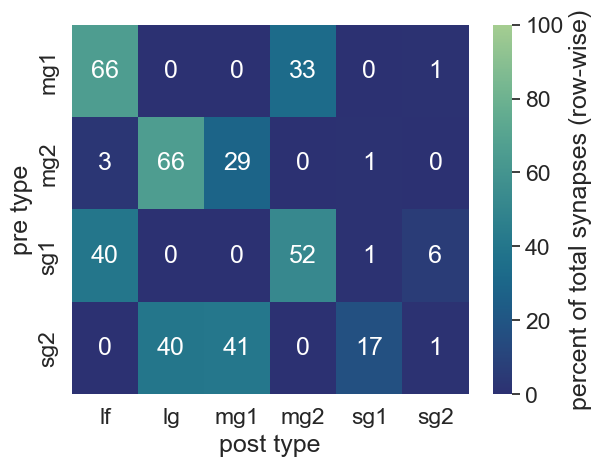

In [1675]:
network_types = ['mg1','mg2','sg1','sg2','lg','lf']#,'sg1','sg2','grc','aff']

res = df_edges[(df_edges['pre_type'].isin(network_types))&(df_edges['post_type'].isin(network_types))].groupby(
    ['pre_type','post_type'])[['weight']].sum(numeric_only=True)#.reset_index()

denom = res.groupby('pre_type')['weight'].sum()

res.weight = np.round(res.weight / denom *100)

# res.reset_index().pivot(index='pre_type', columns='post_type', values='weight').fillna(0)

display(res.reset_index().pivot(index='pre_type', columns='post_type', values='weight').fillna(0))

ax = sns.heatmap(res.reset_index().pivot(index='pre_type', columns='post_type', values='weight').fillna(0),
            annot=True,cmap="crest_r",vmin=0,vmax=100,
           cbar_kws={'label': 'percent of total synapses (row-wise)'})

ax.set_xlabel('post type')
ax.set_ylabel('pre type')

Use following for network from PREsynaptic labeling

In [1141]:
df_edges=df_syn_pre[['pre','post']].value_counts().reset_index(name='weight')

In [1142]:
for i,r in df_edges.iterrows():
    df_edges.loc[i,'pre_type']=cell_type[str(df_edges.loc[i,'pre'])]
    df_edges.loc[i,'post_type']=cell_type[str(df_edges.loc[i,'post'])]

# for each unique edge, get the cell-type pair and structure
# for i,r in df_edges.iterrows():
#     ell.add_edge(r['pre'],r['post'],weight = r['weight'])#r['weight_norm'])#,structure = r['structure'])

In [1143]:
network_types = ['mg1','mg2','lg','lf','sg1','sg2','grc','aff']

df_edges = df_edges[(df_edges['pre_type'].isin(network_types))&(df_edges['post_type'].isin(network_types))]

post_type,aff,grc,mg1,mg2,sg1,sg2
pre_type,,,,,,
grc,51.0,47.0,0.0,0.0,2.0,0.0
mg1,0.0,39.0,0.0,17.0,0.0,44.0
mg2,4.0,11.0,23.0,0.0,62.0,0.0
sg1,0.0,99.0,0.0,0.0,0.0,1.0
sg2,5.0,26.0,0.0,0.0,68.0,0.0


Text(41.25, 0.5, 'post type')

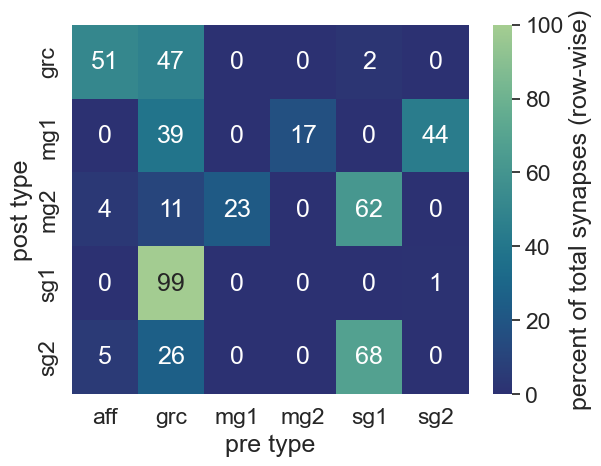

In [1144]:
res = df_edges[(df_edges['pre_type'].isin(network_types))&(df_edges['post_type'].isin(network_types))].groupby(
    ['post_type','pre_type'])[['weight']].sum(numeric_only=True)#.reset_index()

denom = res.groupby('pre_type')['weight'].sum()

res.weight = np.round(res.weight / denom *100)

# res.reset_index().pivot(index='pre_type', columns='post_type', values='weight').fillna(0)

display(res.reset_index().pivot(index='pre_type', columns='post_type', values='weight').fillna(0))

ax = sns.heatmap(res.reset_index().pivot(index='pre_type', columns='post_type', values='weight').fillna(0),
            annot=True,cmap="crest_r",vmin=0,vmax=100,
           cbar_kws={'label': 'percent of total synapses (row-wise)'})

ax.set_xlabel('pre type')
ax.set_ylabel('post type')

In [1145]:
palette ={"lg": "#ff0000", "lf": "#0000ff", "mg1": "#fd9400", "mg2": "#9934ff", "sg1":"#ffff00", "sg2":"#ff33cc", "sgx":"#a6a6a6", "grc":"#000000", "aff":"#000000"}
sns.set(font_scale=1.5)

In [ ]:
# colors = ["#fd9400", "#9934ff"] #color_structure = {'mg1':'#fd9400', 'mg2':'#9934ff'}
# # Set your custom color palette
# sns.set_palette(sns.color_palette(colors))

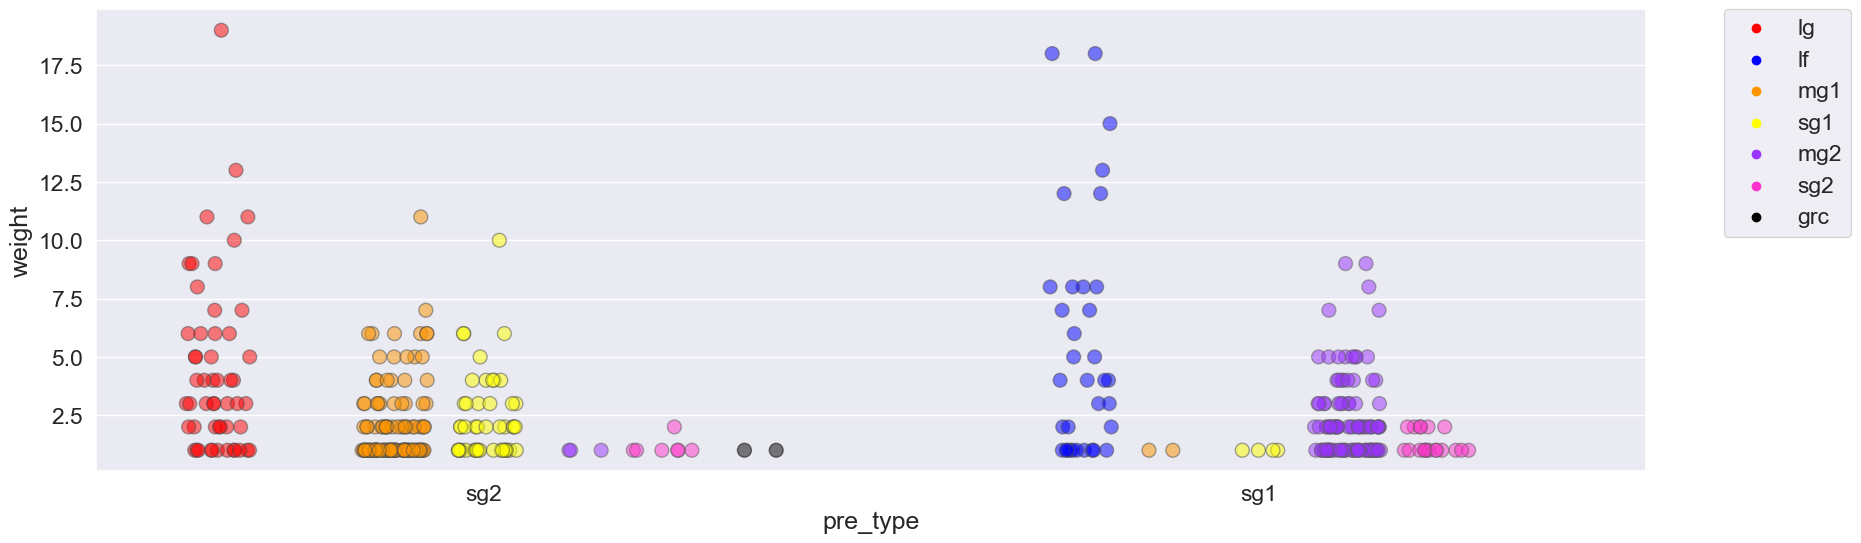

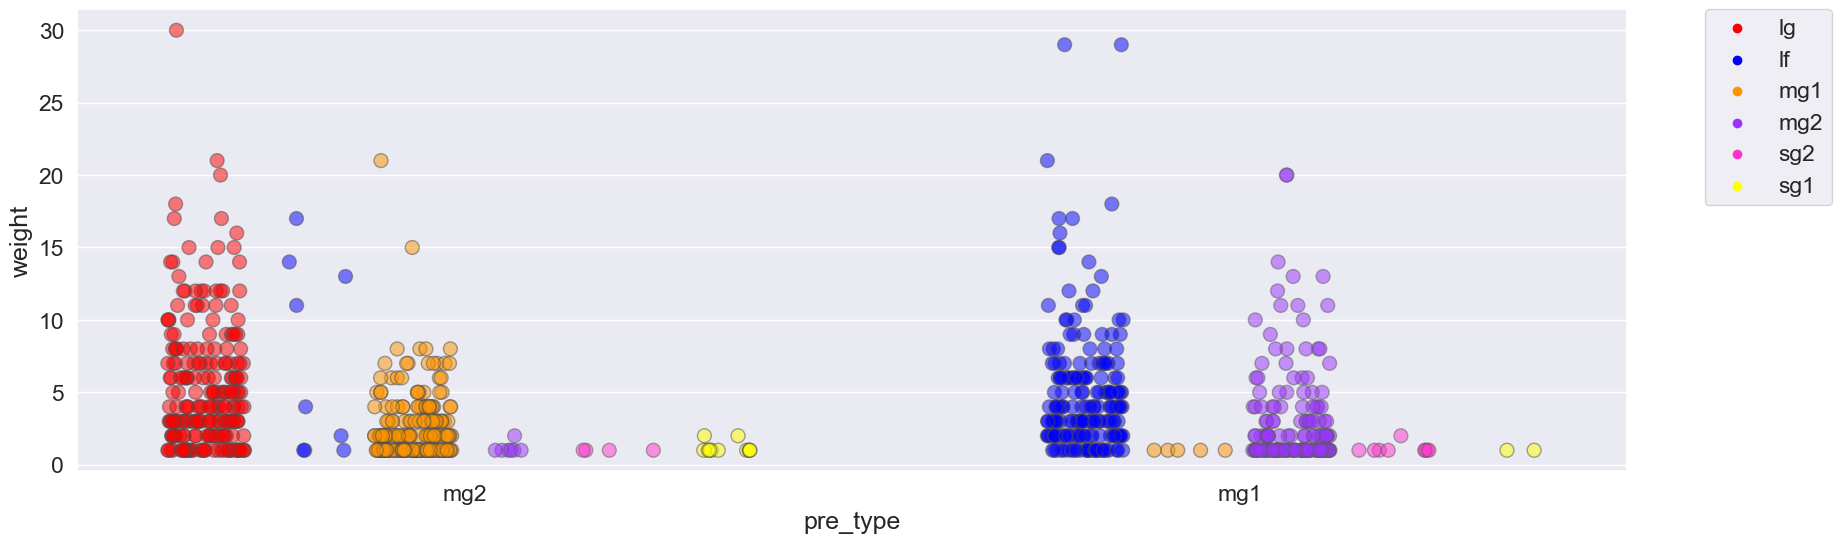

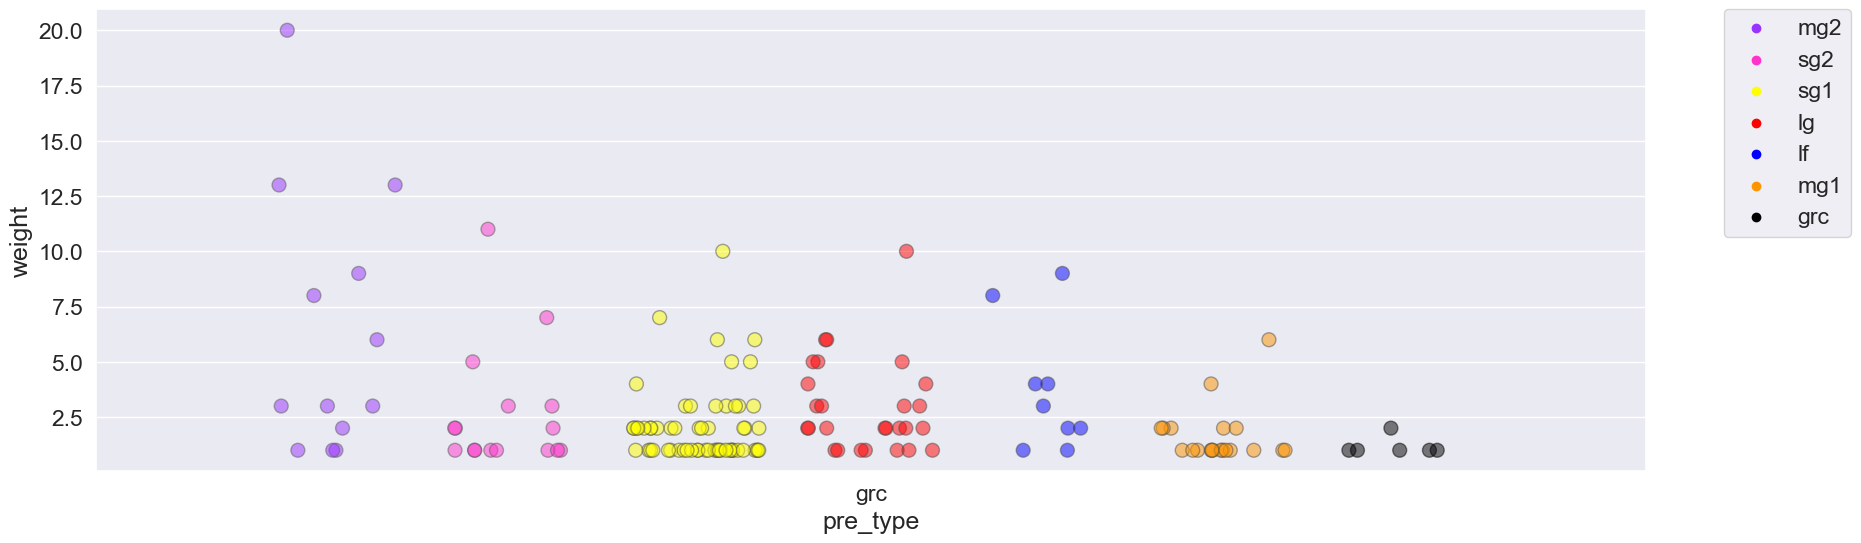

In [1151]:
# with sns.set(font_scale=1.5): # df_edges['weight'].hist(bins=20)
plt.figure(figsize=(20,6))
sns.stripplot(df_edges[df_edges["pre_type"].str.contains('sg')],x='pre_type',y='weight',hue='post_type', edgecolors="black",linewidth=1,
              dodge=True, jitter=0.3,alpha = 0.5,s=10,palette=palette)#,split=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# sns.displot(df_edges,x='weight',hue='pre_type',multiple='dodge')

plt.figure(figsize=(20,6))
sns.stripplot(df_edges[df_edges["pre_type"].str.contains('mg')],x='pre_type',y='weight',hue='post_type', edgecolors="black",linewidth=1,
              dodge=True, jitter=0.3,alpha = 0.5,s=10,palette=palette)#,split=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# sns.displot(df_edges,x='weight',hue='pre_type',multiple='dodge')

plt.figure(figsize=(20,6))
sns.stripplot(df_edges[df_edges["pre_type"].str.contains('grc')],x='pre_type',y='weight',hue='post_type', edgecolors="black",linewidth=1,
              dodge=True, jitter=0.3,alpha = 0.5,s=10,palette=palette)#,split=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# sns.displot(df_edges,x='weight',hue='pre_type',multiple='dodge')

In [ ]:
plt.figure(figsize=(10,4))
sns.violinplot(df_edges,x='pre_type',y='weight',scale='count',cut=0,palette=palette);
# plt.figure(figsize=(10,4))
# sns.kdeplot(df_edges,x='weight',hue='pre_type',bw_adjust = 0.5)

In [ ]:
plt.figure(figsize=(15,8))
sns.violinplot(df_edges,x='post_type',y='weight',scale='count',cut=0,palette=palette)
sns.stripplot(df_edges,x='post_type',y='weight',color='black',alpha=0.5,jitter=0.3);
# plt.figure(figsize=(10,4))
# sns.kdeplot(df_edges,x='weight',hue='post_type',bw_adjust = 0.5)

In [ ]:
degree_in = ell.degree(mode="in")
degree_out = ell.degree(mode="out")

df_degree = pd.DataFrame({
    'cell_id': [v['name'] for v in ell.vs],
    'converge': degree_in,
    'diverge': degree_out,
    'type': [cell_type[v['name']] for v in ell.vs]
})

with pd.option_context('display.max_rows', 4):
    display(df_degree)

In [ ]:
# sns.kdeplot(df_degree,x='converge',hue='type', bw_adjust = 0.75)
plt.figure(figsize=(10,6))
sns.violinplot(df_degree[(df_degree.converge != 0)],x='type',y='converge',scale='count',cut=0,palette=palette,order=['lg','lf','mg1','mg2','sg1','sg2','sgx'])
# plt.figure(figsize=(10,4))
sns.swarmplot(df_degree[(df_degree.converge != 0)],x='type',y='converge',color='black',alpha=0.5)#,jitter=0.25)
# sns.stripplot(df_degree,x='type',y='converge',alpha=0.5,jitter=0.25)

plt.figure(figsize=(10,4))
sns.violinplot(df_degree[(df_degree['type'].isin(['mg1','mg2','sg1','sg2','sgx'])) & (df_degree.diverge != 0)],y='diverge',x='type',scale='count',cut=0,palette=palette)
# plt.figure(figsize=(10,4))
sns.swarmplot(df_degree[(df_degree['type'].isin(['mg1','mg2','sg1','sg2','sgx'])) & (df_degree.diverge != 0)],x='type',y='diverge',color='black',alpha=0.5)

In [ ]:
# sns.displot(df_degree[df_degree['type'].isin(['mg1','mg2','mgx'])],x='diverge',hue='type',multiple='dodge')

tmp = df_degree[(df_degree['type'].isin(['mg1','mg2'])) & (df_degree.diverge != 0) & (df_degree.converge != 0)].melt(id_vars=['type'], 
            value_vars=['converge', 'diverge'])

hfig,ax = plt.subplots(figsize=(10,4))
sns.violinplot(tmp,y='value',x='type',hue = 'variable',split=True,scale='count',cut=0,palette={"converge": "#808080", "diverge": "#d0d0d0"},inner=None)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.set(ylim=(0, 40))

In [ ]:
display(df_degree[(df_degree['type'].isin(['mg1','mg2']))])

In [ ]:
display(df_degree[(df_degree['type'].isin(['mg1','mg2']))& (df_degree.diverge != 0) & (df_degree.converge != 0)])

In [ ]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if 'mg' in b['cell_type']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="out")


In [ ]:
degree_in = pruned_graph.degree(mode="in")
degree_out = pruned_graph.degree(mode="out")

df_degree = pd.DataFrame({
    'cell_id': [v['name'] for v in pruned_graph.vs],
    'converge': degree_in,
    'diverge': degree_out,
    'type': [cell_type[v['name']] for v in pruned_graph.vs]
})

with pd.option_context('display.max_rows', 4):
    display(df_degree)

In [ ]:
# sns.displot(df_degree[df_degree['type'].isin(['mg1','mg2','mgx'])],x='diverge',hue='type',multiple='dodge')

tmp = df_degree[(df_degree.diverge != 0) & (df_degree.converge != 0)].melt(id_vars=['type'], 
            value_vars=['converge', 'diverge'])

hfig,ax = plt.subplots(figsize=(10,4))
sns.violinplot(tmp,y='value',x='type',hue = 'variable',split=True,scale='count',cut=0,palette={"converge": "#808080", "diverge": "#d0d0d0"},inner=None)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.set(ylim=(0, 40))

In [ ]:
color_dict = {"mg1": "orange", "lf": "red", "mg2": "purple", "lg": "blue"}

# for cell_type in ell.vs["cell_type"]:

for v in ell.vs:
    try:
        v["color"] = color_dict[v['cell_type']]
    except:
        v["color"] = 'black'
# ell.vs["color"] = [try: color_dict[cell_type] except: 'black' for cell_type in ell.vs["cell_type"]]

In [ ]:
color_dict = {"unknown": "brown", "apical dendrite": "red", "basal dendrite": "orange", "axon": "green", "multiple":"gray"}

# for cell_type in ell.vs["cell_type"]:

for e in ell.es:
    try:
        e["color"] = color_dict[e['structure']]
    except:
        e["color"] = 'black'
        # print(e)

In [ ]:
degree_all = ell.degree(mode="in")

# for i,d in enumerate(degree_all):
    # print(ell.vs[i]['cell_type'],d)

# labels = [n['name'] for n in ell.vs]

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all
# visual_style["arrow_size"]=0.1


ig_plot(ell,edge_width = ell.es['weight'],
        vertex_color=ell.vs['color'],
        edge_color = ell.es['color'], 
        **visual_style)#,vertex_label=labels)

In [ ]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if 'mg' in b['cell_type']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="out")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'],
        **visual_style)#,vertex_label=labels)

In [ ]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if b['cell_type'] in ['mg2','mgx','lg','lx']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="out")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'], 
        **visual_style)#,vertex_label=labels)

In [ ]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if b['cell_type'] in ['mg2','mgx','lf','lx']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="in")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'], 
        **visual_style)#,vertex_label=labels)

In [ ]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if b['cell_type'] in ['mg1','mgx','lf','lx']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="out")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'], 
        **visual_style)#,vertex_label=labels)

In [ ]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if b['cell_type'] in ['mg1','mgx','lg','lx']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="in")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'], 
        **visual_style)#,vertex_label=labels)

## Get all pre-synaptic cells to a specific cellID

In [ ]:
df_edges[df_edges['post']=='393063300'].groupby('pre').sum(numeric_only=True)

## Check for duplicates in mg_network

In [378]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    

In [379]:
crest = ecrest(settings_dict,launch_viewer=False)

base_segments = crest.get_base_segments_dict(dirpath)

In [ ]:
df_all = pd.DataFrame()
for k,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    df = cell.check_duplicates(base_segments)
    if not df.empty:
        df_all = pd.concat([df_all,df]) 
        
display(df_all)

# Distribution segment locations per cell type

# create crest files for post-syn segments not in cells

In [233]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    

# Create a base_segments dictionary of all cells

base_segments = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    base_segments[cell.cell_data['metadata']['main_seg']['base']] = cell.cell_data['base_segments']

In [234]:
pre_type = 'aff'

# todo_dict= {}
# post_segs_without_cell = 0
# post_segs_with_cell = 0
df_ = {}

all_syn = set()
for x_pre in nodes:
    pre = ecrest(settings_dict,filepath = nodefiles[x_pre],launch_viewer=False)

    # report if the cell is not cell-typed
    if (pre.get_ctype('manual') == []) | (pre.get_ctype('manual') == ''):
        print(f'cell {x_pre} is not cell-typed in json')
    
    # check if the cell is a cell of type pre_type and if it has post-synaptic segments labeled
    if (pre_type in pre.get_ctype('manual')) & (pre.cell_data['end_points']['post-synaptic'] != []):

        try:
        # for each synapse
            syn_to_find = set([syn_[3] for syn_ in pre.cell_data['end_points']['post-synaptic']])
            for x_post in nodes:
                post_segs = set([a for b in base_segments[x_post].values() for a in b])    
                syn_to_find = syn_to_find.difference(post_segs)

            all_syn = all_syn.union(syn_to_find)
        
        except IndexError as msg:
                # cellid = x_pre['name']
                print(msg, f'for cell {pre.cell_data["metadata"]["main_seg"]["base"]} -- {syn_} at least one synapse has no segment id')
                
    if (pre_type in pre.get_ctype('manual')) & (pre.cell_data['end_points']['post-synaptic'] == []):
        # print(f'{pre.cell_data["metadata"]["main_seg"]["base"]} is a {pre.get_ctype("manual")} cell and does not have synapses labelled')
        df_[pre.cell_data["metadata"]["main_seg"]["base"]] = pre.get_ctype("manual")
        

list index out of range for cell 61319896 -- at least one synapse has no segment id


In [238]:
pre = ecrest(settings_dict,filepath = nodefiles['61319896'],launch_viewer=False)

In [241]:
for syn_ in pre.cell_data['end_points']['post-synaptic']:
    if len(syn_)==3:
        print(array([int(syn_[x]/vx_sizes[x]) for x in range(3)]))
        

[16980 20552  2433]
[15229 21713  3204]


In [338]:
# pd.DataFrame.from_dict(df_,orient='index',columns=['type']).reset_index(names='cell')

In [339]:
len(all_syn)

234

In [340]:
base_segments = crest.get_base_segments_dict(Path(settings_dict['save_dir']) / 'todo_postsynaptic_mg')

In [341]:
topop=set()
for k,v in base_segments.items():
    if all_syn & v != set():
        # print(f'use reconstruction {k}')
        topop = topop.union(all_syn & v)
    

In [342]:
len(topop)

10

In [343]:
all_syn = all_syn.difference(topop)

In [344]:
len(all_syn)

224

In [345]:
base_segments = crest.get_base_segments_dict(Path(settings_dict['save_dir']) / 'todo_postsynaptic_sg')

In [346]:
topop=set()
for k,v in base_segments.items():
    if all_syn & v != set():
        # print(f'use reconstruction {k}')
        topop = topop.union(all_syn & v)
    

In [347]:
len(topop)

8

In [348]:
all_syn = all_syn.difference(topop)

In [349]:
len(all_syn)

216

In [ ]:
todo_dict = {}
for post_seg in list(all_syn):
    post = ecrest(settings_dict,segment_id = post_seg,launch_viewer=False)
    todo_dict[post_seg] = set(post.cell_data['base_segments']['unknown'])
    # post_segs_without_cell+=1
    

In [351]:
len(todo_dict)

216

In [352]:
topop=[]

todo_inds = list(todo_dict.keys())
for k,k_ in itertools.combinations(todo_inds,2):
    if todo_dict[k]&todo_dict[k_]!=set():
        # then they share segments
        topop.append(k_)
topop = np.unique(topop)

In [353]:
len(topop)

50

In [354]:
for segid in topop:
    todo_dict.pop(segid)
    

In [ ]:
for segment_id in sorted(list(todo_dict.keys())):

    cell = ecrest(settings_dict,segment_id = segment_id, launch_viewer=False)
    cell.save_cell_graph(directory_path = Path(settings_dict['save_dir']) / 'todo_postsynaptic_grc')
    



# Find & Delete GLIA "post-synaptic" segments from jsons



In [ ]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    

In [ ]:
glia_seg = ['479108445']

In [ ]:
anno_to_remove = {}

vx_sizes = [16, 16, 30]
# for each node,
for n in nodes:

    # if the node has post-synaptic annotations (the current cell is assumed pre-synaptic)
    pre = ecrest(settings_dict,filepath = nodefiles[n],launch_viewer=False)
    if pre.cell_data['end_points']['post-synaptic'] != []:
        
        for syn_ in pre.cell_data['end_points']['post-synaptic']:
            try: 
                if syn_[3] in glia_seg:
                    anno_to_remove[nodefiles[n]] = syn_


            except IndexError as msg:
                # cellid = x_pre['name']
                print(msg, f'for cell {pre.cell_data["metadata"]["main_seg"]["base"]} -- at least one synapse has no segment id')

In [ ]:
anno_to_remove

In [ ]:
f = '/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/todo_post-synaptic/glia/cell_graph_43621743__2023-04-20 08.33.58.json'
pre = ecrest(settings_dict,filepath = f,launch_viewer=True)

In [ ]:
# filepath = json_path / filename
for f,anno in anno_to_remove.items():
    pre = ecrest(settings_dict,filepath = f,launch_viewer=False)
    updated_anno = [i for i in pre.cell_data['end_points']['post-synaptic'] if i[3] not in [anno[3]]]
    pre.cell_data['end_points']['post-synaptic'] = updated_anno
    
    # print(f.name)
    pre.save_cell_graph(directory_path = f.parent, file_name=f.name, save_to_cloud=False); 
    # print(len(pre.cell_data['end_points']['post-synaptic']),len(updated_anno))

# GET most recent files (by filename date) in folder

In [1927]:
# dirname = 'C:/Users/mpetkova/Dropbox/U19_zebrafish/EMfullres/LateralLineCurlDetector/CREST/right_afferents/'
# # os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:/Users/EngertLab/Dropbox/CREST/mariela_fish_credentials.json'

# names = os.listdir(dirname);
# cellid_filename=list();
# for ind in range(len(names)):
#     content = names[ind].split('_')
#     if ('cell' in content):
#         cellid_filename.append(names[ind])
dirpath = Path('/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network')#/todo_pre-synaptic/sg2')#/todo_pre-synaptic/basal-dendrite')

cellid_filename = [child.name for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

d={}
for name in cellid_filename:
    ID,content_type,date=name.split('_')[2], name.split('_')[0], name.split('_')[-1]
    date=date[:-5]
    #create entry in dict which holds ID, file type (ex: cell_graph) and file path
    if ID not in d:
        d[ID]=[date, name]
        #if there are multiple files with the same ID, keep the info for the newest one
    else:
        if date>d[ID][0]:
            d[ID][0]=date
            d[ID][1]=name
            print(f'newer file exists for {ID}')
            
# ############################################################################################################################ 
# # Collect all the base segments for each ID
# import json

# base_segs = {}

# for key in d.keys():
#     f = open(dirname+d[key][1])
#     data = json.load(f)
#     base_segs[key]=sum(data['base_segments'].values(),[])
#     f.close()

# ############################################################################################################################ 


# to find a specific synapse by segment ID'''

In [1517]:
json_path = Path(settings_dict['save_dir']) #/ 'todo_post-synaptic' #/ 'check-duplicates' #'CC unsure'
filename = 'cell_graph_41579854__2023-08-02 11.06.21.json'

crest = ecrest(settings_dict,filepath= json_path / filename, launch_viewer=True)


updating viewer status message: Current Base Segment Counts: unknown: 1250, axon: 90, basal dendrite: 72, apical dendrite: 856, dendrite: 0, multiple: 4


In [1518]:
segment_id = '222459685'

location = [int(syn_[i]/vx_sizes[i]) for syn_ in crest.cell_data['end_points']['post-synaptic'] if syn_[3] in [segment_id] for i in range(3)]

with crest.viewer.txn(overwrite=True) as s:
    s.position = array(location)
    print(location)

# [np.asarray(syn_[0:2])/16 for syn_ in crest.cell_data['end_points']['post-synaptic'] if syn_[3] in [segment_id]]

[10004, 19140, 1618]


In [1519]:
crest.save_cell_graph()

Saved cell 41579854 reconstruction locally at 2023-08-02 11.06.21


# TODO reconstruction files from synapses

In [1853]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

json_path = Path(settings_dict['save_dir']) #/ 'todo_post-synaptic' #/ 'check-duplicates' #'CC unsure'
filename = 'cell_graph_482680782__2023-08-10 20.41.45.json'

crest = ecrest(settings_dict,filepath= json_path / filename, launch_viewer=False)


In [1854]:
syn_type = 'pre-synaptic'

vx_sizes = [16, 16, 30]

# syn_to_find = set([syn_[3] for syn_ in crest.cell_data['end_points'][syn_type] if int(syn_[1]/vx_sizes[1])])
syn_to_find = set()
for syn_ in crest.cell_data['end_points'][syn_type]:
    try:
        syn_to_find.add(syn_[3])
        # post_seg = syn_[3]
        # syn_ = array([int(syn_[i]/vx_sizes[i]) for i in range(3)])

    except IndexError as msg:
        cellid = x_pre
        print(msg, f'for cell {cellid} synapse at {array([int(syn_[i]/vx_sizes[i]) for i in range(3)])} has no segment id')


len(syn_to_find)

162

First, find if any of these post-synaptic segments are already part of reconstructions completed

In [1855]:
base_segments = crest.get_base_segments_dict(Path(settings_dict['save_dir']))# / 'todo_presynaptic')# / 'todo_afferent')#'todo_postsynaptic_grc') 

topop=set()
for k,v in base_segments.items():
    if syn_to_find & v != set():
        # print(f'use reconstruction {k}')
        topop = topop.union(syn_to_find & v)
    

len(topop)

29

Adjust "syn_to_find" to eliminate these base segments from the todo list

In [1856]:
syn_to_find = syn_to_find.difference(topop)

len(syn_to_find)

133

In [1479]:
syn_to_find

{'215622947'}

create crest files for each of the unidentified post-synaptic partners

Save reconstructed_segs as a json to go through manually

In [956]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)


In [1857]:
todo_folder_path = Path(settings_dict['save_dir']) / 'kp/482680782_grc'

for segment_id in sorted(list(syn_to_find)):

    cell = ecrest(settings_dict,segment_id = segment_id, launch_viewer=False)
    cell.save_cell_graph(directory_path = todo_folder_path)#'todo_presynaptic/Krista/sgx_394470350')#/Krista/mg_214581797')

Creating base segment graph for cell 140280342 Cell Reconstruction
all base locations for 5 obtained from SQL database
graph created among all_base_segs
1 clusters of connected components. Connecting these clusters with nearest base segments.
weak clusters connected
segments without a location connected
1 clusters in graph (note should/would be only 1 if loaded base ID from agglomo fresh)
Created a CREST instance for NEW Reconstruction of 140280342. No file saved yet -- save manually.
Saved cell 140280342 reconstruction locally at 2023-08-10 20.43.06
Creating base segment graph for cell 142584684 Cell Reconstruction
all base locations for 2 obtained from SQL database
graph created among all_base_segs
1 clusters of connected components. Connecting these clusters with nearest base segments.
weak clusters connected
segments without a location connected
1 clusters in graph (note should/would be only 1 if loaded base ID from agglomo fresh)
Created a CREST instance for NEW Reconstruction of 

# Other

## Fix cell_data dictionary keys


In [ ]:
filepath = Path("/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/")
filepath = filepath / "cell_graph_228366816__2023-06-14 09.56.22.json"

In [ ]:
cell = ecrest(settings_dict,filepath = filepath,launch_viewer=False)

In [ ]:
old_points = cell.cell_data['end_points']
old_points

In [ ]:
end_points = {}
for p in cell.point_types:
    # if p not in cell.cell_data['end_points']:
    end_points[p] = []
        
cell.cell_data['end_points'] = end_points

In [ ]:
cell.cell_data['end_points']['natural end'] = old_points['natural']

In [ ]:
# cell.cell_data['end_points'].pop('natural')
cell.cell_data['end_points'].keys()

In [ ]:
cell.save_cell_graph(directory_path = filepath.parent, file_name=filepath.name, save_to_cloud=False); #rewrites the original, not with a new time stamp

## Figure out what is wrong with a crest file

In [ ]:
filepath = Path("/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/")
filepath = filepath / "cell_graph_213605530__2023-03-29 22.49.21.json"
cell = ecrest(settings_dict,filepath = filepath,launch_viewer=False)

In [ ]:
cell.cell_data['end_points']['post-synaptic']

## Fix pre-synaptic to be post-synaptic annotation list in converted crest jsons

In [ ]:
json_fix = Path("/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/Complete/synapses/to-crest/conversion_specs_synapse_fix.json")

with open(json_fix,'r') as f:
    cells_to_fix = f.read()
    cells_to_fix = json.loads(cells_to_fix)

In [ ]:
cells_to_fix = cells_to_fix['cell_info']

In [ ]:
for k,v in cells_to_fix.items():
    try:
        filepath = nodefiles[k]
        cell = ecrest(settings_dict,filepath = filepath,launch_viewer=False)
        cell.cell_data['end_points']['post-synaptic'] = deepcopy(cell.cell_data['end_points']['pre-synaptic'])

        cell.cell_data['end_points']['pre-synaptic'] = []
        # cell.save_cell_graph(directory_path = filepath.parent / 'original', file_name=filepath.name, save_to_cloud=False); #rewrites the original, not with a new time stamp
    except KeyError as msg:
        print(msg)
        continue
        

## Anatomical Clustering